# COGS 108 - Final Project 

# Overview

Our team investigated the affect of state shutdowns on the spread rate of covid-19. In order to do so, we gathered data on covid-19 testing results, deaths, and hospitalizations over time for each state and will compate those with and without shutdowns according to each state's population size and density. By calculating the daily infection rate of each state and comparing shutdown states to non-shutdown states as well as the infection rate increase during shutdowns and after reopening, we demonstrated differences but concluded no significance to those differences through T-tests.

# Names

- Kara Chen
- Che-Wei, Lin
- Anthony Chi
- Mario Lopez

# Research Question

Do the shutdown orders of US states have an affect on the covid-19 infection rates of those states?

## Background and Prior Work

Ever since the first case of COVID-19 was confirmed in Wuhan on December 1st, 2019, billions of lives around the world have been affected due to the virus’ rapid transmission and unknown nature. As a result the economy has come to a halt, businesses have shuttered, and schools have been forced to either shut down or engage in online learning. As college students who are affected by this policy, we are interested in examining how the shutdowns have affected the states and if they're efficient in slowing the infection rate of the virus. We believe this is an important task to do because 183,000 people and counting have passed away due to this virus and our goal is to understand how we will be able to prevent more deaths and perhaps finally end the pandemic.

Covid-19 is known to spread mostly by person-to-person contact. Respiratory droplets produced when an infected person coughs, sneezes or talks can be inhaled into the lungs by another person. A person can also come in contact with the virus from touching objects exposed to the droplets then touching their mouth or nose. Because many infected people are asymptomatic, they may not know they're infected and accidently expose others. According to the CDC, the most efficient way to prevent infection is to avoid being exposed to the virus by staying home and keeping a social distance. In order comply with these suggestions and to reduce risk, many states have issues stay-at-home orders or state shutdowns so that people will minimize interacting with others and stop spreading the virus.

The University of Maryland has presented the COVID-19 Impact Analysis which demonstrates the affects of covid-19 in each state. The collected data shows how well people are socially distancing and staying home by tracking things like trips further than a mile from home, and the overall number of trips people are taking and the total distance traveled. Using this information, the social distancing index was calculated for each state and could be compared to the number of covid-19 cases and their death rates. After states issues shutdown orders, this index was shown to have increased by double for most states. Despite this, there isn't as much of correlation between the social distancing index and reported rates of covid-19 cases as states hoped to have. This may demonstrate that the social distancing isn't as helpful to controlling the virus spread as previously thought or perhaps the lack of affect is due to the low numbers of people choosing to take the stay-at-home orders seriously. This will be further investigated in our analysis.

References (include links):
- 1) https://www.cdc.gov/coronavirus/2019-ncov/prevent-getting-sick/prevention.html
- 2) Maryland Transportation Institute (2020). University of Maryland COVID-19 Impact Analysis Platform, https://data.covid.umd.edu, accessed on [6/1/20], University of Maryland, College Park, USA.

# Hypothesis


Our hypothesis is that the states that ordered shutdowns will have a lower rate of covid-19 infection compared to states that didn't shut down at all. 

We believe that the shutdowns have decreased the chances of people coming into contact with the virus and further spreading it to others. Having the states on high alert should also cause the populations to be more cautious when out in public and follow the health regulations that have been suggected to them.

# Dataset(s)

### Historic State Data
- https://covidtracking.com/api/v1/states/daily.json
- 5281 observations as of 6/07/20 (updated daily)
- This panel dataset includes US states and territories and has 35 features. It is accessed theough the COVID Tracking Project's API

### Historic US Data
- https://covidtracking.com/api/v1/us/daily.json
- 138 observations as of 6/07/20 (updated daily)
- This dataset contains 25 features and consists of the cumulative numbers for all states and territories

### State Status Data
- https://www.nytimes.com/interactive/2020/us/states-reopen-map-coronavirus.html
- 50 observations
- This dataset was made by Kara using data from the New York Times. It includes the dates that states ordered and lifted shelter-in-place restrictions along with data for states that have regional reopenings.

### State Population Data
- 50 observations
- This dataset includes population, density, and land acre data for every state

Our main dataset for this project will be the Historic State Dataset. We plan on using the status dataset to add variables that let us know if a state was shutdown, opened, or regionally opened for any date. The population dataset allows us to create variables that measure metrics relative to a state's size and observe how something like tests per 100k citizens change over time. 

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 44em; }</style>"))

# Setup

In [2]:
## YOUR CODE HERE
# Imports - these are all the imports needed for this assignment
# --  the below line gave a UsageError for me
#%mathplotlib inline
from datetime import datetime
import datetime 
from datetime import timedelta
from scipy.stats import ttest_ind, ttest_ind_from_stats
from scipy.special import stdtr

from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')

import urllib.request
import numpy as np
import pandas as pd
# import geopandas as gpd
import requests 
import os

import json
import warnings

pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = ( 17, 5 ) # edit to best view
plt.rcParams.update({'font.size': 16})
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

# import shapely.geometry as shp

import sklearn.neighbors as skn
import sklearn.metrics as skm


pd.set_option('display.max_columns', None)

# Setting Data Up

In [3]:
# Requesting state data from api
req = requests.get('https://covidtracking.com/api/v1/states/daily.json')
data = req.json()
daily = pd.DataFrame(data)


# Requesting US data from api
req_usa = requests.get("https://covidtracking.com/api/v1/us/daily.json")
us_data = req_usa.json()
usa = pd.DataFrame(us_data)


# State shutdown data
status_fp = os.path.join("data", "Shutdown status - Sheet1.csv")
status = pd.read_csv(status_fp)


# State population data
pop_fp = os.path.join("data", "population.csv")
pop = pd.read_csv(pop_fp)

# Data Cleaning

For all datasets, the dates were modified to be a string and in the form year-month-day to enable compatibility.

To clean the <b>usa</b> data for the daily covid-19 status for the country, the US territories that weren't states were dropped, the shutdown statuses were merged from the shutdown data.

To clean the <b>daily</b> data for the daily covid-19 status for each state, unnecessary columns were dropped, US territories were dropped, and columns of booleans added for shutdown status using shutdown data.

To clean the <b>status</b> data for the shutdown and reopening statuses and dates for each state, the columns were given more appropriate names, the state names were converted to their abbreviations, and the shutdown statuses were changed to True/False instead of 1/0. Data not applicable for a state was given NA instead of 0. Data is sorted in alphabetical order by state.

To clean the <b>population</b> data for the population size and density of each state, the state names were converted to their abbreviations. The rest of the data was kept the same because they're in a usable form of integers.

In [4]:
# Cleaning usa data
usa["date"] = usa["date"].astype(str)
usa["date"] = pd.to_datetime(usa["date"])

usa = usa.drop(columns = ["dateChecked", "lastModified", "hash"], axis = 1)

In [5]:
# Convert date to correct format
daily["date"] = daily["date"].astype(str)
daily["date"] = pd.to_datetime(daily["date"])


# Drop irrelevant columns
daily = daily.drop(columns = ["dataQualityGrade", "lastUpdateEt", "dateModified",
                              "checkTimeEt", "dateChecked", "fips", "hash", 
                              "commercialScore", "negativeRegularScore",
                              "negativeScore", "positiveScore", "score", "grade"])


# Removing US territories: American Samoa, Guam, Puerto Rico, Marshall Islands, Virgin Islands
territories = ["AS", "GU", "PR", "MP", "VI"]
daily = daily[~daily["state"].isin(territories)].reset_index(drop = True)


# Impute NaN's with 0's for first day of tests returning as positive for all states
first_cases = daily[daily["totalTestResultsIncrease"].isna()].index
daily.loc[first_cases] = daily.loc[first_cases].fillna(0)

In [6]:
# Better names for columns
status.columns = status.columns.str.lower()
status = status.rename(columns = {"unnamed: 0": "state", "regional reopening": "regional_date"})


# Booleans for shutdown
status["regional"] = ~(status["regional_date"] == "0")
status["shutdown"] = status["shutdown"].astype("bool")


# Remove Puerto Rico
status = status[~(status["state"] == "Puerto Rico")].reset_index(drop = True)


# Convert state status to correct datetime format
status.iloc[:, 2:5] = status.iloc[:, 2:5].replace({"0": np.NaN})
status["shutdown_date"] = pd.to_datetime(status["shutdown_date"])
status["reopen_date"] = pd.to_datetime(status["reopen_date"])
status["regional_date"] = pd.to_datetime(status["regional_date"])


# Convert state names to abbreviations
abbrev = {'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ',
          'Arkansas': 'AR', 'California': 'CA', 'Colorado': 'CO',
          'Connecticut': 'CT', 'Delaware': 'DE', 'District of Columbia': 'DC',
          'Florida': 'FL', 'Georgia': 'GA', 'Hawaii': 'HI', 'Idaho': 'ID',
          'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS',
          'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME',
          'Maryland': 'MD', 'Massachusetts': 'MA', 'Michigan': 'MI',
          'Minnesota': 'MN', 'Mississippi': 'MS', 'Missouri': 'MO',
          'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV',
          'New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM',
          'New York': 'NY', 'North Carolina': 'NC', 'North Dakota': 'ND',
          'Ohio': 'OH', 'Oklahoma': 'OK', 'Oregon': 'OR',
          'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC',
          'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX',
          'Utah': 'UT', 'Vermont': 'VT', 'Virginia': 'VA', 'Washington': 'WA',
          'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY'
          }


status["state"] = status["state"].apply(lambda x: abbrev[x])
status = status.sort_values(by = ["state"]).reset_index(drop = True)

In [7]:
# Change to state abbreviations and sort by state
pop["State"] = pop["State"].apply(lambda x: abbrev[x])
pop.columns = pop.columns.str.lower()
pop = pop.sort_values(by = ["state"]).reset_index(drop = True)

pop.head()

,state,density,pop,landarea
0,AK,1.2863,734002,570641
1,AL,96.9221,4908621,50645
2,AR,58.4030,3038999,52035
3,AZ,64.9550,7378494,113594
4,CA,256.3727,39937489,155779


In [8]:
def to_timerange(start, stop):
    if isinstance(start, datetime.datetime):
        return pd.date_range(start, list(stop)[0])
    elif isinstance(stop, datetime.datetime):
        return pd.date_range(list(start)[0], stop)
    else:
        return pd.date_range(list(start)[0], list(stop)[0])

    
def in_range(timestamp, time_range):
    if timestamp in time_range:
        return True
    else:
        return False

In [9]:
no_shutdown = {"AR", "IA", "NE", "ND",
               "OK", "SD", "UT", "WY"}

regional = {"CA", "NY", "OR", "WA"}

tentative_open = {"MI", "ME"}

reopen = set(status["state"]) - (no_shutdown | regional | tentative_open)

status.head()

,state,shutdown,shutdown_date,reopen_date,regional_date,regional
0,AK,True,2020-03-28,2020-04-21,NaT,False
1,AL,True,2020-04-04,2020-04-30,NaT,False
2,AR,False,NaT,NaT,NaT,False
3,AZ,True,2020-03-31,2020-05-15,NaT,False
4,CA,True,2020-03-19,NaT,2020-05-12,True


In [10]:
# Adding bool values to represent each state's status for a given date
daily["shutdown"], daily["opened"], daily["regional open"] = np.NaN, np.NaN, np.NaN

In [11]:
# States that never shutdown
no_shutdown_index = daily["state"].isin(no_shutdown)
daily.loc[no_shutdown_index, "shutdown"] = False
daily.loc[no_shutdown_index, "opened"] = True
daily.loc[no_shutdown_index, "regional open"] = False


# States that shutdown and have reopened
for i in reopen:
    index = daily["state"] == i
    dates = status[status["state"] == i]
    trange = to_timerange(dates["shutdown_date"], dates["reopen_date"])
    daily.loc[index, "shutdown"] = daily.loc[index, "date"].apply(in_range, args = (trange,))
    daily.loc[index, "opened"] = ~daily.loc[index, "date"].apply(in_range, args = (trange,))
    daily.loc[index, "regional open"] = False

    
# States that are regionally open
for i in regional:
    state = daily[daily["state"] == i]
    status_row = status[status["state"] == i]
    
    preshut_range = to_timerange(min(state["date"]), status_row["shutdown_date"])[:-1]
    shut_range = to_timerange(status_row["shutdown_date"], status_row["regional_date"])[:-1]
    region_range = to_timerange(status_row["regional_date"], max(state["date"]))
    
    preshut_bool = state["date"].apply(in_range, args = (preshut_range,))
    preshut_index = preshut_bool[preshut_bool == True].index
    shut_bool = state["date"].apply(in_range, args = (shut_range,))
    shut_index = shut_bool[shut_bool == True].index
    regional_bool = state["date"].apply(in_range, args = (region_range,))
    regional_index = regional_bool[regional_bool == True].index
    
    daily.loc[preshut_index, ["shutdown", "opened", "regional open"]] = [False, True, False]
    daily.loc[shut_index, ["shutdown", "opened", "regional open"]] = [True, False, False]
    daily.loc[regional_index, ["shutdown", "opened", "regional open"]] = [False, False, True]
    
    
# Michigan/Maine
for i in tentative_open:
    state = daily[daily["state"] == i]
    status_row = status[status["state"] == i]
    
    preshut_range = to_timerange(min(state["date"]), status_row["shutdown_date"])[:-1]
    shut_range = to_timerange(status_row["shutdown_date"], status_row["regional_date"])[:-1]
    region_range = to_timerange(status_row["regional_date"], status_row["reopen_date"])[:-1]
    open_range = to_timerange(status_row["reopen_date"], max(state["date"]))
    
    preshut_bool = state["date"].apply(in_range, args = (preshut_range,))
    preshut_index = preshut_bool[preshut_bool == True].index
    shut_bool = state["date"].apply(in_range, args = (shut_range,))
    shut_index = shut_bool[shut_bool == True].index
    regional_bool = state["date"].apply(in_range, args = (region_range,))
    regional_index = regional_bool[regional_bool == True].index
    reopen_bool = state["date"].apply(in_range, args = (open_range,))
    reopen_index = reopen_bool[reopen_bool == True].index
    
    daily.loc[preshut_index, ["shutdown", "opened", "regional open"]] = [False, True, False]
    daily.loc[shut_index, ["shutdown", "opened", "regional open"]] = [True, False, False]
    daily.loc[regional_index, ["shutdown", "opened", "regional open"]] = [False, False, True]
    daily.loc[reopen_index, ["shutdown", "opened", "regional open"]] = [False, True, False]

In [12]:
daily["cases_per_100k"], daily["tests_per_100k"], daily["deaths_per_100k"] = np.NaN, np.NaN, np.NaN
daily["positive_test_rate"] = np.NaN


daily["cases_per_100k"] = daily["state"].apply(lambda x: pop[pop["state"] == x].values[0, 2])
daily["tests_per_100k"] = daily["cases_per_100k"]
daily["deaths_per_100k"] = daily["cases_per_100k"]


daily["cases_per_100k"] = (1e5 * (daily["positive"] / daily["cases_per_100k"])).round(2)
daily["tests_per_100k"] = (1e5 * (daily["totalTestResults"] / daily["tests_per_100k"])).round(2)
daily["deaths_per_100k"] = (1e5 * (daily["death"] / daily["deaths_per_100k"])).round(2)


daily["positive_test_rate"] = daily["positive"] / daily["totalTestResults"]

daily

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,death,hospitalized,totalTestsViral,positiveTestsViral,negativeTestsViral,positiveCasesViral,positiveIncrease,negativeIncrease,total,totalTestResults,totalTestResultsIncrease,posNeg,deathIncrease,hospitalizedIncrease,shutdown,opened,regional open,cases_per_100k,tests_per_100k,deaths_per_100k,positive_test_rate
0,2020-06-10,AK,593.0,67127.0,NaN,22.0,NaN,NaN,NaN,3.0,NaN,392.0,11.0,NaN,67720.0,NaN,NaN,NaN,20,810,67720,67720,830,67720,0,0,False,True,False,80.79,9226.13,1.50,0.008757
1,2020-06-10,AL,21989.0,251068.0,NaN,629.0,2129.0,NaN,646.0,NaN,378.0,13508.0,744.0,2129.0,NaN,NaN,NaN,21626.0,567,4751,273057,273057,5318,273057,15,42,False,True,False,447.97,5562.80,15.16,0.080529
2,2020-06-10,AR,10368.0,165849.0,NaN,181.0,901.0,NaN,NaN,49.0,147.0,7116.0,165.0,901.0,NaN,NaN,NaN,10368.0,288,10148,176217,176217,10436,176217,4,36,False,True,False,341.16,5798.52,5.43,0.058837
3,2020-06-10,AZ,29852.0,269835.0,NaN,1274.0,3476.0,413.0,NaN,273.0,NaN,5851.0,1095.0,3476.0,299687.0,NaN,NaN,NaN,1556,4918,299687,299687,6474,299687,25,70,False,True,False,404.58,4061.63,14.84,0.099611
4,2020-06-10,CA,136191.0,2404607.0,NaN,4719.0,NaN,1326.0,NaN,NaN,NaN,NaN,4776.0,NaN,2540798.0,NaN,NaN,136191.0,2702,51851,2540798,2540798,54553,2540798,79,0,False,False,True,341.01,6361.94,11.96,0.053602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5009,2020-01-26,WA,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,1,0,1,0,0,False,True,False,0.01,0.01,NaN,1.000000
5010,2020-01-25,WA,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,1,0,1,0,0,False,True,False,0.01,0.01,NaN,1.000000
5011,2020-01-24,WA,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,1,0,1,0,0,False,True,False,0.01,0.01,NaN,1.000000
5012,2020-01-23,WA,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,1,0,1,0,0,False,True,False,0.01,0.01,NaN,1.000000


A simple dataframe that merges a few columns from each dataset is created to be used in EDA to view correlations.

In [13]:
#Single dataframe (simple version for eda)

compiled = pop
compiled = compiled.drop(columns=['landarea'])
compiled = compiled.join(status['shutdown'])
compiled = compiled.join(daily['positive_test_rate'])
compiled = compiled.join(daily['hospitalized'])
compiled = compiled.join(daily['death'])
compiled = compiled.rename(columns={'pop': 'population'})

#drop states empty values
compiled = compiled.dropna()

#changed index to state
compiled.set_index('state')

compiled.head()

,state,density,population,shutdown,positive_test_rate,hospitalized,death
1,AL,96.9221,4908621,True,0.080529,2129.0,744.0
2,AR,58.4030,3038999,False,0.058837,901.0,165.0
3,AZ,64.9550,7378494,True,0.099611,3476.0,1095.0
5,CO,56.4011,5845526,True,0.125377,5025.0,1553.0
6,CT,735.8689,3563077,True,0.139934,9669.0,4120.0


In [14]:
print(compiled.columns)
print(daily.columns)

Index(['state', 'density', 'population', 'shutdown', 'positive_test_rate',
       'hospitalized', 'death'],
      dtype='object')
Index(['date', 'state', 'positive', 'negative', 'pending',
       'hospitalizedCurrently', 'hospitalizedCumulative', 'inIcuCurrently',
       'inIcuCumulative', 'onVentilatorCurrently', 'onVentilatorCumulative',
       'recovered', 'death', 'hospitalized', 'totalTestsViral',
       'positiveTestsViral', 'negativeTestsViral', 'positiveCasesViral',
       'positiveIncrease', 'negativeIncrease', 'total', 'totalTestResults',
       'totalTestResultsIncrease', 'posNeg', 'deathIncrease',
       'hospitalizedIncrease', 'shutdown', 'opened', 'regional open',
       'cases_per_100k', 'tests_per_100k', 'deaths_per_100k',
       'positive_test_rate'],
      dtype='object')


# Exploratory Data Analysis

During the exploration of the datasets, we attempted to find correlations between the state shutdown statuses, population, and covid-19 statuses (deaths, hospitalizations, positive tests, etc.)

In the visualizations, red represents data for shutdown states, blue represents data for non-shutdown states, and purple represents data for both state statuses.

In [15]:
#To merge daily and compiled df into one
#this Def expects to see daily first then compiled, also works wirh shutdown_compiled and noshutdown_compiled
# compiled has no nan, doing this replaces any nan in these columns with the right number
def merge2Df(Day, other):
    Day = Day.drop(['hospitalized', 'shutdown', 'positive_test_rate','hospitalized'], axis=1)
    other = other.drop(['death'], axis = 1)
    merged_df = Day.merge(other, how = 'inner', on = ['state'])
    return merged_df
#method to adjust values based on state population
#divide each hospitalization and death # by population to make hospital/death rate?
#This is known as the Death-to-hospitalization or Death2Hospit
#the passed in var is the Dataframe 
def adjust_popratio(num):
    num['Death_to_hospitalization'] = num.apply(lambda row: row.hospitalized / row.death if ~pd.isnull(row.hospitalized) and row.death > 0 else float("nan"), axis=1)
    return num

#method to adjust values based on state population
#divide each death and positve# by population to make death/positive rate?
#This is known as the positve-to-death ratio or Positve2Death
#the passed in var is the Dataframe 
def adjust_PositveDeathratio(num):
    num['positve_to_death']= num.apply(lambda row: row.death / row.positive if ~pd.isnull(row.death) and row.positive > 0 else float("nan"), axis=1)
    return num
    
#method to caluate infection rate forumla: #infected/#population at risk * 100
#This will result in a percentage from 100 - 0
def cal_infectionRate(num):
    num['infection_rate'] = num.apply(lambda row: float(row.positive)/float(row.population) if ~pd.isnull(row.positive) and float(row.population) > 0 else float("nan"), axis=1)
    return num

def cal_deathOverPopulationRatio(num):
    num['death_over_pop'] = num.apply(lambda row: float(row.death)/float(row.population) if ~pd.isnull(row.death) and float(row.population) > 0 else float("nan"), axis=1)
    return num

def cal_hospitalizedOverPopulationRatio(num):
    num['hospitalized_over_pop'] = num.apply(lambda row: float(row.hospitalized)/float(row.population) if ~pd.isnull(row.death) and float(row.population) > 0 else float("nan"), axis=1)
    return num


In [16]:
#separating states with shutdowns vs no shutdowns

compiled = cal_deathOverPopulationRatio(compiled)
compiled = cal_hospitalizedOverPopulationRatio(compiled)
shutdown_compiled = compiled.loc[compiled['shutdown'] == True]
noshutdown_compiled = compiled.loc[compiled['shutdown'] == False]

#removing shutdown column
shutdown_compiled = shutdown_compiled.drop(['shutdown'], axis=1)
noshutdown_compiled = noshutdown_compiled.drop(['shutdown'], axis=1)

allData = merge2Df(daily, compiled)
allData = allData.rename(columns={'pop': 'population'})
#allData.pop = allData.pop.astype(float)
allData = adjust_popratio(allData)
allData = adjust_PositveDeathratio(allData)

allData = cal_infectionRate(allData)
allData = cal_deathOverPopulationRatio(allData)
allData = cal_hospitalizedOverPopulationRatio(allData)
allData

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,death,totalTestsViral,positiveTestsViral,negativeTestsViral,positiveCasesViral,positiveIncrease,negativeIncrease,total,totalTestResults,totalTestResultsIncrease,posNeg,deathIncrease,hospitalizedIncrease,opened,regional open,cases_per_100k,tests_per_100k,deaths_per_100k,density,population,shutdown,positive_test_rate,hospitalized,death_over_pop,hospitalized_over_pop,Death_to_hospitalization,positve_to_death,infection_rate
0,2020-06-10,AL,21989.0,251068.0,NaN,629.0,2129.0,NaN,646.0,NaN,378.0,13508.0,744.0,NaN,NaN,NaN,21626.0,567,4751,273057,273057,5318,273057,15,42,True,False,447.97,5562.80,15.16,96.9221,4908621,True,0.080529,2129.0,0.000152,0.000434,2.861559,0.033835,0.004480
1,2020-06-09,AL,21422.0,246317.0,NaN,600.0,2087.0,NaN,631.0,NaN,375.0,11395.0,729.0,NaN,NaN,NaN,21071.0,497,7251,267739,267739,7748,267739,11,33,True,False,436.42,5454.46,14.85,96.9221,4908621,True,0.080529,2129.0,0.000149,0.000434,2.920439,0.034030,0.004364
2,2020-06-08,AL,20925.0,239066.0,NaN,NaN,2054.0,NaN,623.0,NaN,371.0,11395.0,718.0,NaN,NaN,NaN,20590.0,425,0,259991,259991,425,259991,26,32,True,False,426.29,5296.62,14.63,96.9221,4908621,True,0.080529,2129.0,0.000146,0.000434,2.965181,0.034313,0.004263
3,2020-06-07,AL,20500.0,239066.0,NaN,NaN,2022.0,NaN,615.0,NaN,364.0,11395.0,692.0,NaN,NaN,NaN,20166.0,457,13465,259566,259566,13922,259566,3,29,True,False,417.63,5287.96,14.10,96.9221,4908621,True,0.080529,2129.0,0.000141,0.000434,3.076590,0.033756,0.004176
4,2020-06-06,AL,20043.0,225601.0,NaN,NaN,1993.0,NaN,612.0,NaN,363.0,11395.0,689.0,NaN,NaN,NaN,19709.0,656,5515,245644,245644,6171,245644,13,44,True,False,408.32,5004.34,14.04,96.9221,4908621,True,0.080529,2129.0,0.000140,0.000434,3.089985,0.034376,0.004083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3541,2020-03-11,WY,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,True,False,0.00,0.00,NaN,5.8400,567025,False,0.031765,92.0,NaN,0.000162,NaN,NaN,0.000000
3542,2020-03-10,WY,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,True,False,0.00,0.00,NaN,5.8400,567025,False,0.031765,92.0,NaN,0.000162,NaN,NaN,0.000000
3543,2020-03-09,WY,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,True,False,0.00,0.00,NaN,5.8400,567025,False,0.031765,92.0,NaN,0.000162,NaN,NaN,0.000000
3544,2020-03-08,WY,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,True,False,0.00,0.00,NaN,5.8400,567025,False,0.031765,92.0,NaN,0.000162,NaN,NaN,0.000000


[Text(0, 0.5, 'State'), Text(0.5, 0, 'Positive Test Rate')]

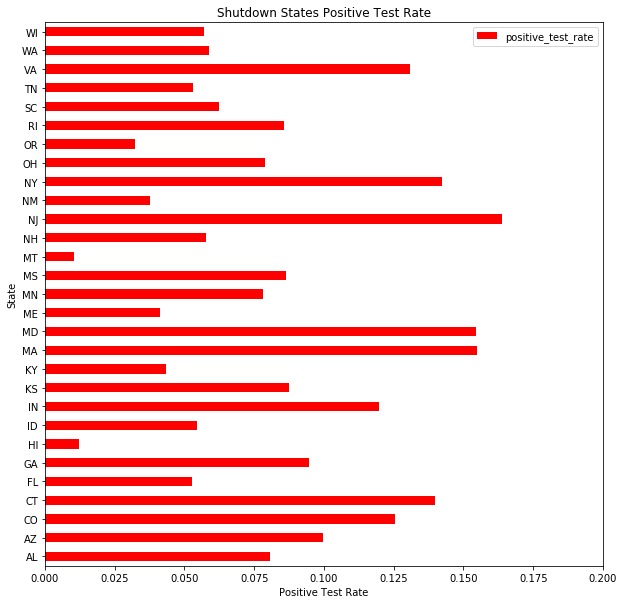

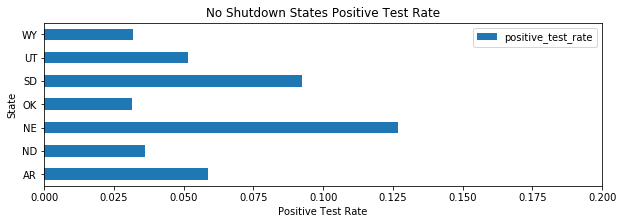

In [17]:
#shutdown states positive_test_rate
ax = shutdown_compiled.plot.barh(title='Shutdown States Positive Test Rate', x='state',xlim=(0,0.20), y=['positive_test_rate'], figsize=(10, 10), color='red')
ax.set(xlabel='Positive Test Rate', ylabel='State')

# noshutdown states positive test rate
axs = noshutdown_compiled.plot.barh(title='No Shutdown States Positive Test Rate', x='state', xlim=(0,0.20), y='positive_test_rate', figsize=(10, 3))
axs.set(xlabel='Positive Test Rate', ylabel='State')

We plotted the deaths, hospitalizations, and positive tests rates in horizontal bar charts to visualize any apparent differences between the shutdown states and no shutdown states. Both had a wide range between the states that represented their shutdown status.

In [18]:
shutdown_compiled.describe()

,density,population,positive_test_rate,hospitalized,death,death_over_pop,hospitalized_over_pop
count,29.000000,2.900000e+01,29.000000,29.000000,29.000000,29.000000,29.000000
mean,268.091186,6.183924e+06,0.082633,7444.655172,2543.137931,0.000327,0.000882
std,322.339778,4.967340e+06,0.043414,16467.016885,4926.535785,0.000394,0.000954
min,7.466800,1.056161e+06,0.010272,74.000000,17.000000,0.000012,0.000059
25%,63.705600,2.910357e+06,0.053063,1583.000000,404.000000,0.000108,0.000362
50%,153.160500,5.700671e+06,0.078853,2943.000000,868.000000,0.000176,0.000532
75%,287.503800,7.378494e+06,0.119768,7981.000000,2355.000000,0.000290,0.000925
max,1215.199100,2.199298e+07,0.163882,89995.000000,24404.000000,0.001385,0.004629


In [19]:
noshutdown_compiled.describe()

,density,population,positive_test_rate,hospitalized,death,death_over_pop,hospitalized_over_pop
count,7.000000,7.000000e+00,7.000000,7.000000,7.000000,7.000000,7.000000
mean,30.029671,2.065754e+06,0.061270,672.428571,143.142857,0.000070,0.000334
std,22.217808,1.372755e+06,0.035980,406.050841,110.714992,0.000028,0.000143
min,5.840000,5.670250e+05,0.031522,92.000000,18.000000,0.000032,0.000162
25%,11.475450,8.323750e+05,0.033890,348.000000,72.500000,0.000047,0.000263
50%,25.416100,1.952570e+06,0.051505,901.000000,128.000000,0.000076,0.000291
75%,48.798850,3.160557e+06,0.075591,971.500000,178.000000,0.000094,0.000401
max,58.403000,3.954821e+06,0.126900,1075.000000,355.000000,0.000100,0.000557


[Text(0, 0.5, 'Positive Test Rates'), Text(0.5, 0, 'Population Density')]

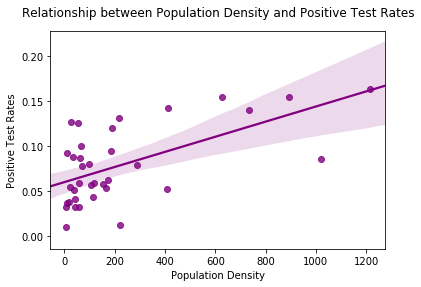

In [20]:
# Does population density and positive test rate have a relationship?
ax = sns.regplot(x='density', y='positive_test_rate', data=compiled, color='purple')
ax.set_title('Relationship between Population Density and Positive Test Rates', pad=15)
ax.set(xlabel='Population Density', ylabel='Positive Test Rates')

In [21]:
# Find out the strength of the relationship by calculating R Square
compiled['density'].corr(compiled['positive_test_rate'])

0.6036648004031693

Plot (1). The plot above shows a strong correlation (0.607) between population density and positive test rates, suggesting states with a higher population density have a higher change of having a high positive test rate.

[Text(0, 0.5, 'Positive Test Rates'), Text(0.5, 0, 'Population Density')]

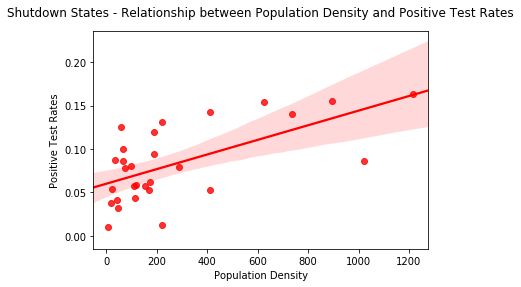

In [22]:
# We can see that for states that are shutdown, population density is higher and relationship is stronger
ax = sns.regplot(x='density', y='positive_test_rate', data=shutdown_compiled, color='red')
ax.set_title('Shutdown States - Relationship between Population Density and Positive Test Rates', pad=15)
ax.set(xlabel='Population Density', ylabel='Positive Test Rates')

In [23]:
# Stronger relationship
shutdown_compiled['density'].corr(shutdown_compiled['positive_test_rate'])

0.6242932573027905

Plot (2). The plot above shows a stronger correlation (0.629) between population density and positive test rates, suggesting shutdown states with a higher population density have a higher change of having a high positive test rate.

[Text(0, 0.5, 'Positive Test Rates'), Text(0.5, 0, 'Population Density')]

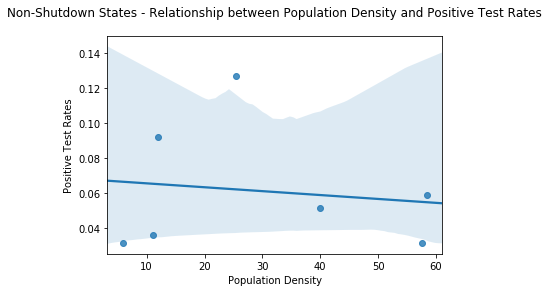

In [24]:
ax = sns.regplot(x='density', y='positive_test_rate', data=noshutdown_compiled)
ax.set_title('Non-Shutdown States - Relationship between Population Density and Positive Test Rates', pad=20)
ax.set(xlabel='Population Density', ylabel='Positive Test Rates')

In [25]:
# Weaker relationship
noshutdown_compiled['density'].corr(noshutdown_compiled['positive_test_rate'])

-0.13763047640848

Plot (3). The plot above shows a weak correlation (-0.13) between population density and positive test rates, suggesting the non states do not possess a correlation between population density and positive test rates. Perhaps this is due to the differing amounts of testing applied to each state.

In [26]:
# Examine pairplot
# colors = ["blue", "red"]
# ax = sns.pairplot(compiled[['density', 'population', 'shutdown', 'positive_test_rate', 'hospitalized', 'death']], hue='shutdown', palette=colors)

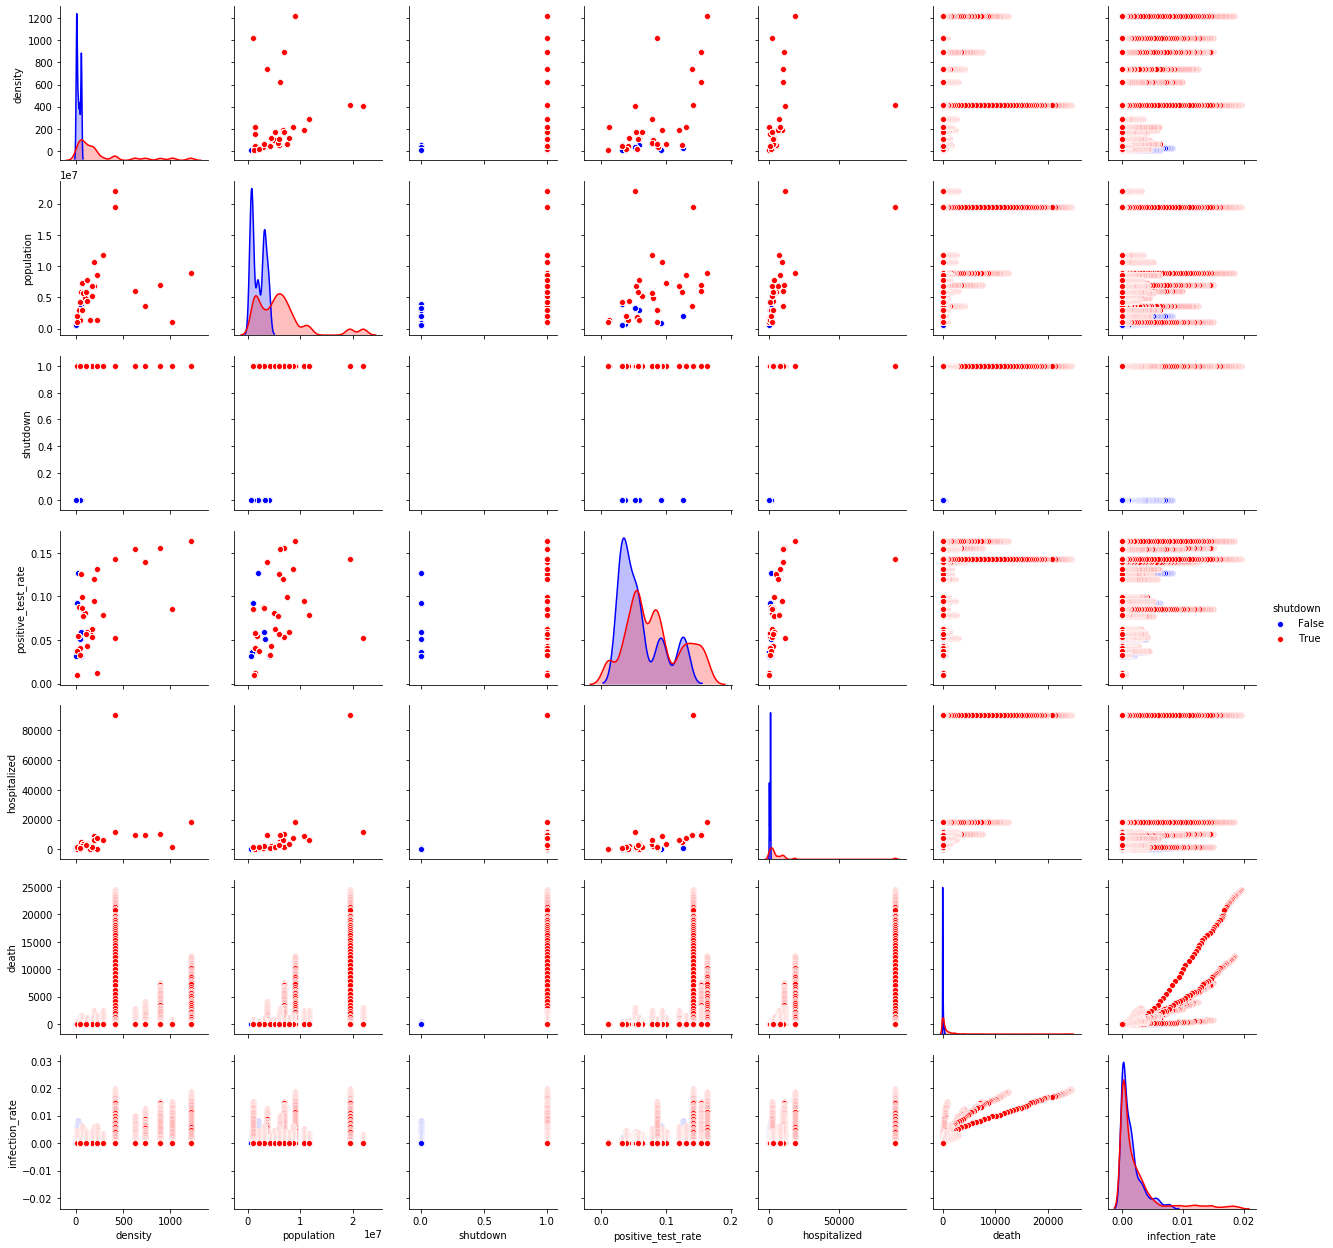

In [27]:

# Examine pairplot
colors = ["blue", "red"]
# ax = sns.pairplot(allData[['density', 'population', 'shutdown', 'positive_test_rate', 'hospitalized', 'death', 'Death_to_hospitalization', 'positve_to_death', 'infection_rate']], hue='shutdown')
ax = sns.pairplot(allData[['density', 'population', 'shutdown', 'positive_test_rate', 'hospitalized', 'death', 'infection_rate']], hue='shutdown', palette=colors)

This plot demonstrates the various relationships between covid-19 effected or effecting categories. It is difficult to interpret due to the lack of states without shutdowns. As in the above regression plots, there seems to be a correlation between population density and positive test rates. There aren't many features distinguishing shutdown state covid-19 statuses and that of non-shutdown states.

# Data Analysis & Results

After exploring the correlations presented in the data, we sought to answer the question of shutdown order effects on the rate of infection of covid-19. To do so, we needed to calculate the daily infection rate of each state which we calculated as number of positive tests divided by population.

Then we separated the shutdown state data and the no shutdown state data in order to find the average of the states with the same status. Averages of infection rate between states for each day reported were calculated and plotted.

In [28]:
# Def to calculate the avg infection rate per day for all of the us
# takes in a DF and returns another DF with 2 colums['date', 'Avg_infection_rate']
def get_Avg_Infection(info):
    data = info.date.drop_duplicates().to_frame()
    data.columns = ['date']
    
    data['Avg_infection_rate'] = data.apply(lambda row: info[info.date == row.date].infection_rate.mean() , axis=1)
        
    return data

In [29]:
#separated shutdown and no shutdown columns, added infection_rates for each date
shutdown_all = allData.loc[allData['shutdown'] == True]
shutdown_all = shutdown_all[['shutdown', 'date', 'infection_rate']]
noshutdown_all = allData.loc[allData['shutdown'] == False]
noshutdown_all = noshutdown_all[['shutdown', 'date', 'infection_rate']]
all_Avg = get_Avg_Infection(allData)
shutdown_Avg = get_Avg_Infection(shutdown_all)
noshutdown_Avg = get_Avg_Infection(noshutdown_all)
shutdown_Avg = shutdown_Avg.reset_index()
noshutdown_Avg = noshutdown_Avg.reset_index()

Text(0.5, 1.0, 'Infection Rate for All States')

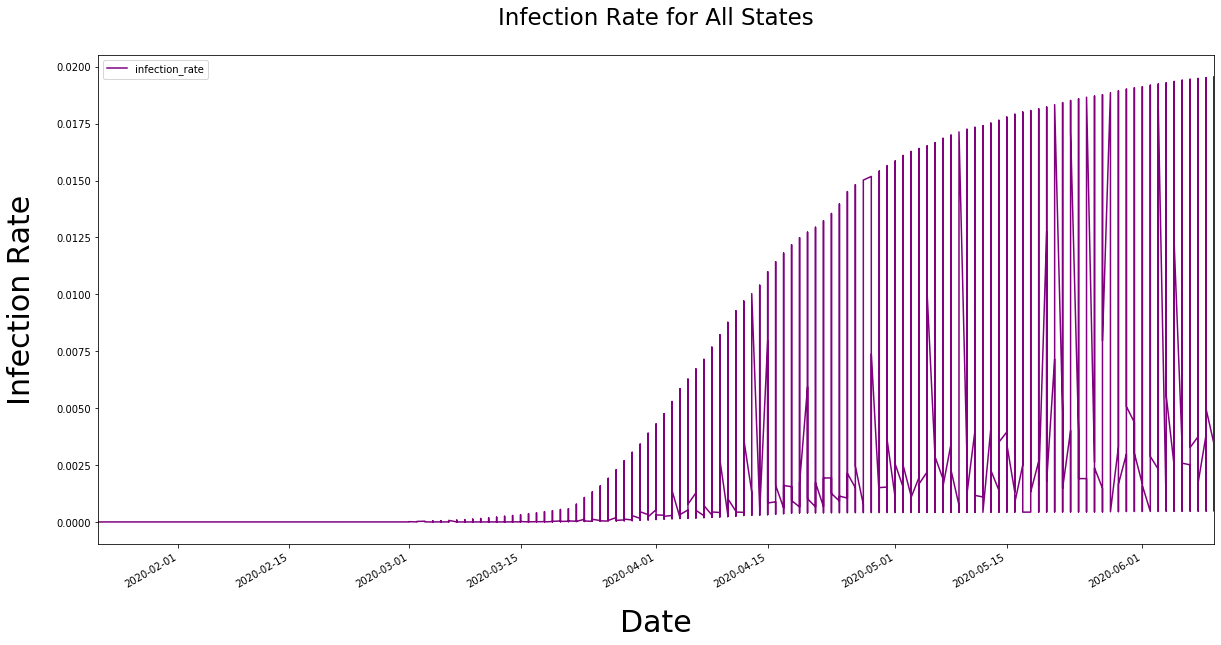

In [30]:
# #infection rate of all states (need to redo)
fig1 = allData.plot.line(x='date', y='infection_rate',figsize=(20, 10), color='purple')
spin1 = fig1.set_xlabel('Date', fontsize=30, labelpad=20)
spin = fig1.set_ylabel('Infection Rate', size=30, labelpad=20)
plt.title('Infection Rate for All States',fontsize= 23, pad=30)

Fig (1). This visualization represents the infection rates for all states since recorded, demonstrating the differing infection rates used in calculating the averages for shutdown states and no shutdown states. There is a wide range of difference between the states in with the same status, perhaps demonstrating lack of correlation between shutdown status and infection rate.

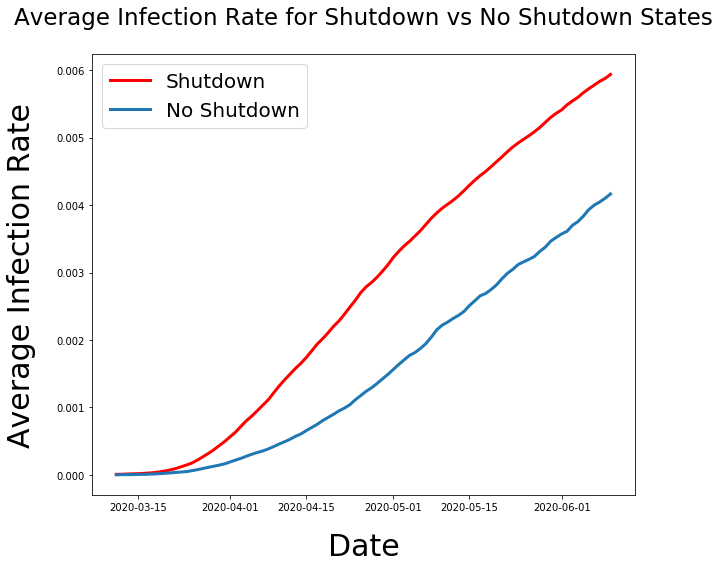

In [31]:
#combine average infection rates for shutdown vs no shutdown
fig2, ax = plt.subplots(figsize=(10, 8))
spin1 = ax.set_xlabel('Date', fontsize=30, labelpad=20)
spin = ax.set_ylabel('Average Infection Rate', size=30, labelpad=20)
# plt.plot(all_Avg.date, all_Avg.Avg_infection_rate, label = 'all states')
plt.plot(shutdown_Avg.iloc[:92].date, shutdown_Avg.iloc[:92].Avg_infection_rate, label = 'Shutdown', color='red', linewidth=3)
plt.plot(noshutdown_Avg.iloc[:92].date, noshutdown_Avg.iloc[:92].Avg_infection_rate, label = "No Shutdown", linewidth=3)
plt.legend(loc=2, prop={'size': 20})
plt.title('Average Infection Rate for Shutdown vs No Shutdown States',fontsize= 23, pad=30)
plt.tight_layout()
plt.show()


Fig(2). This visualization demonstrates that the states with shutdown orders have a higher average infection rate compared to the states without shutdown orders.

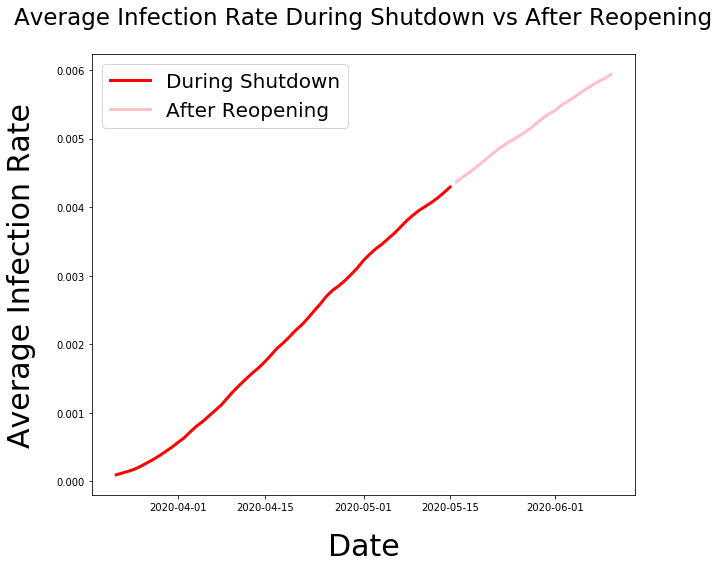

In [32]:
fig2, ax = plt.subplots(figsize=(10, 8))
spin1 = ax.set_xlabel('Date', fontsize=30, labelpad=20)
spin = ax.set_ylabel('Average Infection Rate', size=30, labelpad=20)
# plt.plot(all_Avg.date, all_Avg.Avg_infection_rate, label = 'all states')
plt.plot(shutdown_Avg.iloc[26:81].date, shutdown_Avg.iloc[26:81].Avg_infection_rate, label = 'During Shutdown', color='red', linewidth=3)
plt.plot(shutdown_Avg.iloc[:26].date, shutdown_Avg.iloc[:26].Avg_infection_rate, label = 'After Reopening', color='pink', linewidth=3)
plt.legend(loc=2, prop={'size': 20})
plt.title('Average Infection Rate During Shutdown vs After Reopening',fontsize= 23, pad=30)
plt.tight_layout()
plt.show()

Fig (3). This visualization demonstrates the difference in infection rates after shutdowns and after reopening of the states that did shutdown by highlighting which areas of the curve represent their increase of infection rate. Visually, it seems that the rate of infection increase during the shutdown is higher than the rate of infection increase after reopening.

In [33]:
# pd.set_option('display.max_rows', shutdown_Avg.shape[0]+1)
# print(shutdown_Avg)

# Are shutdown states significantly different from no shutdown and reopening?

In [34]:
print('When comparing the shutdown and no Shutdown avg_infection_rates, we see no real difference between the groups')
print('Shutdown states: mean=%.3f stdv=%.3f' % (np.mean(shutdown_Avg.Avg_infection_rate), np.std(shutdown_Avg.Avg_infection_rate)))
print('No shutdown states: mean=%.3f stdv=%.3f' % (np.mean(noshutdown_Avg.Avg_infection_rate), np.std(noshutdown_Avg.Avg_infection_rate)))
# compare states
stat, p = ttest_ind(shutdown_Avg.Avg_infection_rate, noshutdown_Avg.Avg_infection_rate)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')


When comparing the shutdown and no Shutdown avg_infection_rates, we see no real difference between the groups
Shutdown states: mean=0.002 stdv=0.002
No shutdown states: mean=0.001 stdv=0.001
Statistics=1.355, p=0.177
Same distributions (fail to reject H0)


In [35]:
print('When comparing the shutdown and no Shutdown death_over_pop, we see no real difference between the groups')
print('Shutdown states: mean=%.3f stdv=%.3f' % (np.mean(shutdown_compiled.death_over_pop), np.std(shutdown_compiled.death_over_pop)))
print('No shutdown states: mean=%.3f stdv=%.3f' % (np.mean(noshutdown_compiled.death_over_pop), np.std(noshutdown_compiled.death_over_pop)))
# compare states
stat, p = ttest_ind(shutdown_compiled.death_over_pop, noshutdown_compiled.death_over_pop)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')

When comparing the shutdown and no Shutdown death_over_pop, we see no real difference between the groups
Shutdown states: mean=0.000 stdv=0.000
No shutdown states: mean=0.000 stdv=0.000
Statistics=1.707, p=0.097
Same distributions (fail to reject H0)


In [36]:
print('When comparing the shutdown and no Shutdown hospitalized_over_pop, we see no real difference between the groups')
print('Shutdown states: mean=%.3f stdv=%.3f' % (np.mean(shutdown_compiled.hospitalized_over_pop), np.std(shutdown_compiled.hospitalized_over_pop)))
print('No shutdown states: mean=%.3f stdv=%.3f' % (np.mean(noshutdown_compiled.hospitalized_over_pop), np.std(noshutdown_compiled.hospitalized_over_pop)))
# compare states
stat, p = ttest_ind(shutdown_compiled.hospitalized_over_pop, noshutdown_compiled.hospitalized_over_pop)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')

When comparing the shutdown and no Shutdown hospitalized_over_pop, we see no real difference between the groups
Shutdown states: mean=0.001 stdv=0.001
No shutdown states: mean=0.000 stdv=0.000
Statistics=1.500, p=0.143
Same distributions (fail to reject H0)


In [37]:
print('When comparing the shutdown and reopening Shutdown rate of change of he infection rates, we see a real difference between the groups')
print('Shutdown states: mean=%.3f stdv=%.3f' % (np.mean(shutdown_Avg.iloc[26:81].Avg_infection_rate.pct_change()), np.std(shutdown_Avg.iloc[26:81].Avg_infection_rate.pct_change())))
print('reopening shutdown states: mean=%.3f stdv=%.3f' % (np.mean(shutdown_Avg.iloc[:26].Avg_infection_rate.pct_change()), np.std(shutdown_Avg.iloc[:26].Avg_infection_rate.pct_change())))
# compare states
stat, p = ttest_ind(shutdown_Avg.iloc[26:81].Avg_infection_rate.pct_change(), shutdown_Avg.iloc[:26].Avg_infection_rate.pct_change())
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')

When comparing the shutdown and reopening Shutdown rate of change of he infection rates, we see a real difference between the groups
Shutdown states: mean=-0.066 stdv=0.053
reopening shutdown states: mean=-0.012 stdv=0.002
Statistics=nan, p=nan
Different distributions (reject H0)


In [38]:
print('When comparing the shutdown and no Shutdown rate of change of he infection rates, we see a real difference between the groups')
print('Shutdown states: mean=%.3f stdv=%.3f' % (np.mean(shutdown_Avg.iloc[26:81].Avg_infection_rate.pct_change()), np.std(shutdown_Avg.iloc[26:81].Avg_infection_rate.pct_change())))
print('reopening shutdown states: mean=%.3f stdv=%.3f' % (np.mean(noshutdown_Avg.Avg_infection_rate.pct_change()), np.std(noshutdown_Avg.Avg_infection_rate.pct_change())))
# compare states
stat, p = ttest_ind(shutdown_Avg.iloc[26:81].Avg_infection_rate.pct_change(), noshutdown_Avg.Avg_infection_rate.pct_change())
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')

When comparing the shutdown and no Shutdown rate of change of he infection rates, we see a real difference between the groups
Shutdown states: mean=-0.066 stdv=0.053
reopening shutdown states: mean=-0.101 stdv=0.147
Statistics=nan, p=nan
Different distributions (reject H0)


# Ethics & Privacy

The main data utilized containing state information on covid-19 cases has been released to the public and encouraged to be used by researchers to aid data driven discoveries about the unknown covid-19. The rest of the data such as population density has been published for public knowledge and use. Since the project is focused on state differences, there isn't information on the individual level and therefore no privacy issues. The data collected records individual diagnosis, but does not reveal any patients or persons involved in the data besides their health status and lcoation.

There may be biases developed against certain states that didn't issue stay-at-home orders and put their populations at risk as shown by the data, but this perception should not negatively affect the individuals of those states. Instead, the data revealed may indicate further need for restrictions rather than lifting those restrictions too early. This could improve the safety of those in the states that have taken little action.

The process of the data usage in this analysis is described step by step to ensure transparency of the results discovered. This will allow others to replicate our methods and improve our findings further while honestly presenting the truth of the data. Considering the scope of the analysis, we believe that there are no ethical or privacy issues present in our project.

# Conclusion & Discussion

The data does not support our hypothesis that the states that ordered shutdowns will have a lower rate of covid-19 infection compared to states that didn't shut down at all. According to the data, states that shutdown have a higher infection rate compared to the states that did not shut down. Utilizing the T-test method, it was demonstrated that there is no significance to the difference between the observed infection rates of shutdown states and non-shutdown states. In comparing the deaths over population and hospitalizations over population of shutdown states and non-shutdown states, there was no significance to their differences. The T-test was also utilized to calculate the chance of a significant difference of the increase of infection rate during shutdowns and after reopening. This also led to failing to reject the null hypothesis and demonstrated a lack of significance in the differences shown. Overall, it seems as though the shutdown orders given to the states did not affect the rate of infections for those states in comparison to the states without shutdown orders.

For our analysis, we calculated the daily infection rate of each state and plotted them to compare. We then separated shutdown states from non-shutdown states and found the average daily infection rate of both sets. By plotting those values, we visualize a higher average infection rate of shutdown states compared to non-shutdown states. We then plotted the increase rate of infection during shutdowns and after reopenings to visualize a difference in slope. Despite the differences shown in the visuals, the utilization of T-tests lead to the conclusion of failing to reject the null hypothesis. Thus, there is no shown statistical significance in these differences.

This conclusion may be due to a flaw in the data provided. Although the source of the data is credible, the methods used to provide the data differs between states. The use of testing isn't as widespread in some states and those qualified to take the tests might not represent the general population. Because of the wide range of symptoms caused by covid-19, the reports of hospitalizations and deaths might not be accurate as it isn't always sure that it was covid-19 that caused those cases. It could also be the case that the populations of states that gave shutdown orders did not comply to those orders. Also the shutdown methods of each state varied, therefore not every state was as strict or lenient as the other. It is lack of information about covid-19 and the differing reactions of each state that may have led this analysis to be inconclusive or to show no significance in the effect of shutdown orders.

# Team Contributions

Kara Chen - mostly Write Up/ Descriptions, some EDA and Visualizations

Lin Che-Wei - EDA

Anthony Chi - Data Cleaning

Mario Lopez - mostly the Def and helped other with coding problems. Helped with some EDA and Visualizations